In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import keras
import keras.layers as layers
import tensorflow as tf

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [ ]:
from keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, GRU, Embedding, Flatten
from keras.models import Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras import backend as K
import pickle

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/Enthire/airline_sentiment_analysis.csv")

In [ ]:
df.shape

(11541, 3)

In [ ]:
df.head(5)

,Unnamed: 0,airline_sentiment,text
0,1,positive,@VirginAmerica plus you've added commercials t...
1,3,negative,@VirginAmerica it's really aggressive to blast...
2,4,negative,@VirginAmerica and it's a really big bad thing...
3,5,negative,@VirginAmerica seriously would pay $30 a fligh...
4,6,positive,"@VirginAmerica yes, nearly every time I fly VX..."


In [ ]:
df=df.iloc[:,1:]

In [ ]:
df.iloc[100].text

".@VirginAmerica I don't understand why you need a DM to give me an answer on if you have a damaged luggage policy."

Replace class label positive with 1 and negative with 0

In [ ]:
df['airline_sentiment'][df.airline_sentiment=='positive']=1
df['airline_sentiment'][df.airline_sentiment=='negative']=0

Set aside 15% data for testing

In [ ]:
dftrain,dtest=train_test_split(df,train_size=0.85)

Further split training data between train and validation set

In [ ]:
dtrain,dval=train_test_split(dftrain,train_size=0.85)

In [ ]:
print(dtrain.shape)
print(dval.shape)
print(dtest.shape)

(8337, 2)
(1472, 2)
(1732, 2)


Convert text reviews to numeric values using Tokenizer

In [ ]:
tok_raw = Tokenizer()

raw_text = np.hstack([dtrain.text.str.lower(), dval.text.str.lower(), dtest.text.str.lower()])
tok_raw.fit_on_texts(raw_text)

dtrain["text"] = tok_raw.texts_to_sequences(dtrain.text.str.lower())
dval["text"] = tok_raw.texts_to_sequences(dval.text.str.lower())
dtest["text"] = tok_raw.texts_to_sequences(dtest.text.str.lower())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

In [ ]:
dtrain.head()

,airline_sentiment,text
6641,0,"[18, 55, 7, 360, 193, 4, 1348, 17, 4076, 120, ..."
7870,0,"[12, 118, 41, 10, 55, 216, 444, 1511, 94, 1, 6..."
3181,0,"[5, 44, 202, 253, 682, 81, 275, 9, 64, 561, 6,..."
11363,0,"[13, 406, 727, 17, 11, 8, 43, 482, 175, 85, 41..."
10347,0,"[13, 11, 5711, 8, 257, 272, 22, 33, 79, 339, 3..."


Get the max len of tokenized review. It will also be used when making api calls

In [ ]:
#SEQUENCE VARIABLES ANALYSIS
max_text_seq = np.max( [np.max(dtrain.text.apply(lambda x: len(x))), 
                        np.max(dval.text.apply(lambda x: len(x))),
                        np.max(dtest.text.apply(lambda x: len(x))),
                        ] )
print("max name seq "+str(max_text_seq))

max name seq 36


Plotting histograms to check variations in tokenized review length

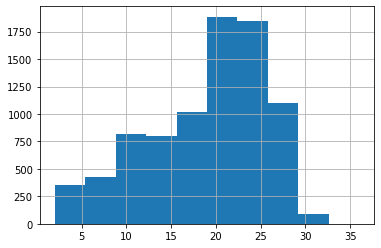

In [ ]:
dtrain.text.apply(lambda x: len(x)).hist()

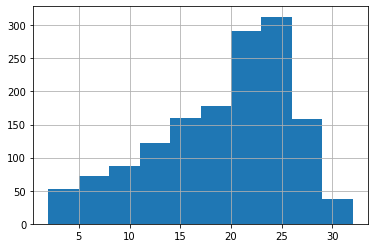

In [ ]:
dval.text.apply(lambda x: len(x)).hist()

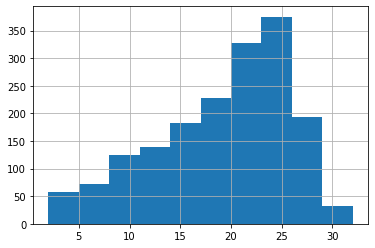

In [ ]:
dtest.text.apply(lambda x: len(x)).hist()

In [ ]:
MAX_TEXT_SEQ = 36

Get the maximum numeric value in the tokenized review

In [ ]:
MAX_TEXT = np.max([np.max(dtrain.text.apply(max)), np.max(dval.text.apply(max)),
                   np.max(dtest.text.apply(max))])+2

In [ ]:
MAX_TEXT

13235

Defining RNN model class

In [ ]:
class RnnModel:

  def get_keras_data(self,dataset):
    X = {
        'text': pad_sequences(dataset.text, maxlen=MAX_TEXT_SEQ)
    }
    return X
  
  def get_model(self):
    #params
    dr_r = 0.15
    
    #Input
    text = Input(shape=[X_train["text"].shape[1]], name="text")
    
    #Embeddings layer
    emb_text = Embedding(MAX_TEXT, 50)(text)
    
    #rnn layer
    rnn_layer1 = GRU(64) (emb_text)
    # using GRU layer for fast training as it has less paramaters than LSTM 
    # and most of the reviews are small

    main_l = rnn_layer1
    main_l = Dropout(dr_r) (Dense(64) (main_l))
    main_l = BatchNormalization() (main_l)
    main_l = Dropout(dr_r) (Dense(32) (main_l))
    main_l = BatchNormalization() (main_l)
    main_l = Dropout(dr_r) (Dense(16) (main_l))
    main_l = BatchNormalization() (main_l)
 
    #output
    output = Dense(1, activation="sigmoid") (main_l)
    
    #model
    model = Model([text], output)
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

In [ ]:
mod=RnnModel()

In [ ]:
X_train = mod.get_keras_data(dtrain)
X_valid = mod.get_keras_data(dval)
X_test  = mod.get_keras_data(dtest)

In [ ]:
model=mod.get_model()

In [ ]:
model.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text (InputLayer)            [(None, 36)]              0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 36, 40)            529400    
_________________________________________________________________
gru_8 (GRU)                  (None, 64)                20352     
_________________________________________________________________
dense_32 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_24 (Dropout)         (None, 64)                0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 64)                256       
_________________________________________________________________
dense_33 (Dense)             (None, 32)              

In [ ]:
BATCH_SIZE = 32
epochs = 15

In [ ]:
model.fit(X_train, dtrain.airline_sentiment.values.astype(int), epochs=epochs, batch_size=BATCH_SIZE
          , validation_data=(X_valid, dval.airline_sentiment.values.astype(int)))

Epoch 1/15
261/261 [==============================] - 7s 28ms/step - loss: 0.4888 - accuracy: 0.7660 - val_loss: 0.4350 - val_accuracy: 0.8030
Epoch 2/15
261/261 [==============================] - 7s 27ms/step - loss: 0.2116 - accuracy: 0.9264 - val_loss: 0.3358 - val_accuracy: 0.8580
Epoch 3/15
261/261 [==============================] - 7s 26ms/step - loss: 0.1145 - accuracy: 0.9620 - val_loss: 0.3690 - val_accuracy: 0.8811
Epoch 4/15
261/261 [==============================] - 7s 27ms/step - loss: 0.0778 - accuracy: 0.9742 - val_loss: 0.4800 - val_accuracy: 0.8845
Epoch 5/15
261/261 [==============================] - 7s 27ms/step - loss: 0.0518 - accuracy: 0.9832 - val_loss: 0.3308 - val_accuracy: 0.8947
Epoch 6/15
261/261 [==============================] - 7s 26ms/step - loss: 0.0359 - accuracy: 0.9878 - val_loss: 0.4058 - val_accuracy: 0.9008
Epoch 7/15
261/261 [==============================] - 7s 27ms/step - loss: 0.0318 - accuracy: 0.9898 - val_loss: 0.5333 - val_accuracy: 0.8655

In [ ]:
model.evaluate(X_test,dtest.airline_sentiment.values.astype(int))

55/55 [==============================] - 0s 5ms/step - loss: 0.4323 - accuracy: 0.9036


[0.43231865763664246, 0.9035796523094177]

Training accuracy: 99%, 
Testing  accuracy: 90% 

Saving the trained tokenizer for tokenizing text review for api calls

In [ ]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tok_raw, handle, protocol=pickle.HIGHEST_PROTOCOL)

Saving the model for inference in api calls 

In [ ]:
model.save("Sentiment_RNN_model.h5")

Using BERT Model

In [ ]:
# !pip install transformers

Getting a pre_trained BERT model and tokenizer from huggingface's tranformers library

In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertForSequenceClassification: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier', 'dropout_75']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Preparing our data for training accoring to BERT's specification

In [ ]:
def convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN): 
  
  train_InputExamples = train.apply(lambda x: InputExample(guid=None,
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

  validation_InputExamples = test.apply(lambda x: InputExample(guid=None, 
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)
  
  return train_InputExamples, validation_InputExamples

In [ ]:
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:

        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )


In [ ]:
df.head()

,airline_sentiment,text
0,1,@VirginAmerica plus you've added commercials t...
1,0,@VirginAmerica it's really aggressive to blast...
2,0,@VirginAmerica and it's a really big bad thing...
3,0,@VirginAmerica seriously would pay $30 a fligh...
4,1,"@VirginAmerica yes, nearly every time I fly VX..."


In [ ]:
train,test=train_test_split(df,train_size=0.85)

In [ ]:
DATA_COLUMN = 'text'
LABEL_COLUMN = 'airline_sentiment'


train_InputExamples, validation_InputExamples = convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(32).repeat(2)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(32)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

model.fit(train_data, epochs=7, validation_data=validation_data)

Epoch 1/7
614/614 [==============================] - 507s 825ms/step - loss: 0.1365 - accuracy: 0.9487 - val_loss: 0.1849 - val_accuracy: 0.9480
Epoch 2/7
614/614 [==============================] - 507s 826ms/step - loss: 0.0259 - accuracy: 0.9917 - val_loss: 0.2116 - val_accuracy: 0.9509
Epoch 3/7
614/614 [==============================] - 507s 826ms/step - loss: 0.0115 - accuracy: 0.9960 - val_loss: 0.2932 - val_accuracy: 0.9411
Epoch 4/7
614/614 [==============================] - 509s 829ms/step - loss: 0.0105 - accuracy: 0.9968 - val_loss: 0.2936 - val_accuracy: 0.9469
Epoch 5/7
614/614 [==============================] - 508s 827ms/step - loss: 0.0068 - accuracy: 0.9977 - val_loss: 0.2595 - val_accuracy: 0.9503
Epoch 6/7
614/614 [==============================] - 507s 826ms/step - loss: 0.0073 - accuracy: 0.9975 - val_loss: 0.2554 - val_accuracy: 0.9555
Epoch 7/7
614/614 [==============================] - 509s 830ms/step - loss: 0.0051 - accuracy: 0.9980 - val_loss: 0.2822 - val_ac

Training Accuracy: 99%, 
Testing Accuracy: 95%